<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MNIST-데이터셋-가져오기" data-toc-modified-id="MNIST-데이터셋-가져오기-1">MNIST 데이터셋 가져오기</a></span></li><li><span><a href="#회귀-구현하기" data-toc-modified-id="회귀-구현하기-2">회귀 구현하기</a></span><ul class="toc-item"><li><span><a href="#Softmax-회귀-모델" data-toc-modified-id="Softmax-회귀-모델-2.1">Softmax 회귀 모델</a></span></li><li><span><a href="#학습하기" data-toc-modified-id="학습하기-2.2">학습하기</a></span></li><li><span><a href="#모델-평가하기" data-toc-modified-id="모델-평가하기-2.3">모델 평가하기</a></span></li></ul></li></ul></div>

tensorflow 1.14 버전을 사용 합니다.
MNIST data에 대한 softmax를 이용한 회귀를 구현 해봅니다.
https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/beginners/ 에서 자세한 내용을 확인할 수 있습니다.

In [2]:
# !pip install tensorflow==1.14
import tensorflow as tf

In [3]:
print(tf.__version__)

1.14.0


### MNIST 데이터셋 가져오기

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
import matplotlib.pyplot as plt

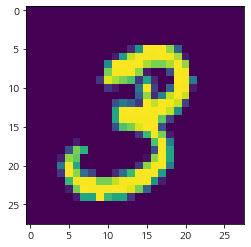

In [7]:
plt.imshow(mnist.train.images[1].reshape(28,28))

In [8]:
mnist.train.labels[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

### 회귀 구현하기

우리가 텐서플로우에서 연산을 실행할 때 값을 입력할 자리를 만듭니다. 
여기서는 784차원의 벡터로 변형된 MNIST 이미지의 데이터를 넣으려고 합니다. 우린 이걸 [None, 784]의 형태를 갖고 부동소수점으로 이루어진 2차원 텐서로 표현합니다. (여기서 None은 해당 차원의 길이가 어떤 길이든지 될 수 있음을 의미합니다)

In [9]:
x = tf.placeholder(tf.float32, [None, 784])

우리의 모델에는 가중치와 바이어스 역시 필요합니다. 텐서플로우는 Variable이라고 불리는 2차원 텐서로 표현합니다. Variable은 서로 상호작용하는 연산으로 이루어진 텐서플로우 그래프 안에 존재하는, 수정 가능한 텐서입니다. Variable은 연산에 사용되기도 하고, 연산을 통해 수정되기도 합니다. 머신러닝에 이를 사용할 때에는 주로 모델의 변수를 Variable들로 사용하게 됩니다.

In [10]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

#### Softmax 회귀 모델

In [11]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

#### 학습하기

우리의 모델을 학습시키기 위해서는 우선 모델이 좋다는 것은 어떤 것인지를 정의해야 합니다. 사실 머신러닝에서는 모델이 안좋다는 것이 어떤 의미인지를 주로 정의합니다. 우리는 이를 주로 비용(cost) 또는 손실(loss)이라고 부르며, 이것들은 우리의 모델이 우리가 원하는 결과에서 얼마나 떨어져있는지를 보여주는 값입니다. 우리는 그 격차를 줄이기 위해 노력하며, 그 격차가 적으면 적을수록 우리의 모델은 좋다고 말합니다.

모델의 손실을 정의하기 위해 자주 사용되는 좋은 함수 중 하나로 "크로스 엔트로피"가 있습니다. 크로스 엔트로피는 다음과 같이 정의됩니다:합

\(y\)는 우리가 예측한 확률 분포이며, \(y'\)는 실제 분포(우리가 입력하는 원-핫 벡터) 입니다. 대략적으로 설명하자면, 크로스 엔트로피는 우리의 예측이 실제 값을 설명하기에 얼마나 비효율적인지를 측정하는 것입니다.

크로스 엔트로피를 구현하기 위해서는 올바른 답을 넣기 위한 새로운 placeholder를 추가하는 것 부터 시작해야 합니다.

크로스 엔트로피 함수는 \(-\sum y'\log(y)\) 입니다.

In [12]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [13]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

텐서플로우는 최적화 알고리즘을 적용하여, 역전파(backpropagation) 알고리즘을 사용하여 변수(파라미터)를 수정 합니다.

In [14]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

우리가 작성한 변수들을 초기화하는 작업을 수행합니다.

In [15]:
init = tf.global_variables_initializer()

Session에서 모델을 실행시키고, 변수들을 초기화 하는 작업을 실행시킬 수 있습니다:

In [16]:
sess = tf.Session()
sess.run(init)

학습을 시킵시다 -- 여기선 학습을 1000번 시킬 겁니다!

반복되는 루프의 각 단계마다, 우리는 학습 데이터셋에서 무작위로 선택된 100개의 데이터로 구성된 "배치(batch)"를 가져옵니다. 그 다음엔 placeholder의 자리에 데이터를 넣을 수 있도록 train_step을 실행하여 배치 데이터를 넘깁니다.

무작위 데이터의 작은 배치를 사용하는 방법을 확률적 학습(stochastic training)이라고 부릅니다 -- 여기서는 확률적 경사 하강법입니다.

In [17]:
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

#### 모델 평가하기

In [18]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [19]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9156


단순한 모델로 정확도가 약 92%가 나왔습니다. 약간만 바꾸면, 97%의 정확도를 얻을 수 있습니다.